# This notebook exemplifies the calculation of the reduction to Pole by using the *classical equivalent layer* approach.

In [1]:
# Import all python modules
import numpy
from matplotlib import pyplot

In [2]:
# Import some developed modules
from codes.prism import prism_gz
from codes.sphere import sphere_gz
from codes.grids import regular_grid
from codes.equivalentlayer import layer, mat_grav

In [3]:
# Data shape:
ndata = 50
shape = (ndata, ndata)

In [4]:
# observations:
xo, yo, zo = regular_grid((-2000., 2000., -2000., 2000.), shape, -200.)

In [45]:
# synthetic data produced by a vertical dike model (vertical attraction):
# (xmin, xmax, ymin, ymax, zmin, zmax, rho(km/m3) )
dike1 = (-300., 150., -100., 280., 100., 750., 2800.0)
dike2 = (1000., 1350., 1400., 1680., 90., 1950., 2900.0)
gz = prism_gz(xo, yo, zo, dike1) + prism_gz(xo, yo, zo, dike2)

In [20]:
# Statistical module
from codes.auxiliars import addnoise
from codes.statistical import analysis

In [21]:
print 'Analysing gz data:'
_ = analysis(gz)

Analysing gz data:
Minimum:    0.0869
Maximum:    6.3167
Mean value: 1.1018
Variation:  6.2298


In [22]:
#tfa = addnoise(tfa, 2., 0.025})
gz = addnoise(gz, 1.0, 0.1)

In [23]:
print 'Analysing gz data noise:'
_ = analysis(gz)

Analysing gz data noise:
Minimum:    0.8783
Maximum:    7.2465
Mean value: 2.1071
Variation:  6.3683


#### Creating the equivalent layer:

In [55]:
# define a mesh of point masses with unit volume:
# 1) horizontal coordinates:
area = (-2000., 2000., -2000., 2000.) # meters
shape_layer = (60,60)
# 2) define the depth of the layer and the number of point in area:
eqlayer = layer( area, shape_layer, 700.)

In [56]:
# computing the Jacobian matrix:
A = mat_grav(xo, yo, zo, eqlayer)

In [57]:
# dimensions of the sensitivity matrix of the eqlayer problem:
M = shape_layer[0] * shape_layer[1]
N = shape[0] * shape[1]
print N,M

2500 3600


### Solve the least-square problem for the two possible cases:

In [73]:
# Estimation of vector parameters:
if N >= M: #overdetermined case
    mu    = 0.0 #10**(-2)
    I     = numpy.identity(M)
    trace = numpy.trace(A.T.dot(A)) / M
    vec   = numpy.linalg.solve( numpy.dot(A.T, A) + mu * trace * I, numpy.dot(A.T, gz) )
else:# underterminated case
    mu    = 10**(-2)
    I     = numpy.identity(N)
    trace = numpy.trace(A.T.dot(A)) / N
    aux   = numpy.linalg.solve( numpy.dot(A, A.T) + mu * trace * I,  gz )
    vec   = numpy.dot(A.T, aux)

In [76]:
# Compute the data produced by the layer to see if it's right:
print aux.shape

gz_predicted = numpy.dot(A, vec)
gz_predicted.shape

(2500,)


(2500,)

In [77]:
print 'Analysing gz predicted:'
_ = analysis(gz_predicted)
print 'Analysing gz noise:'
_ = analysis(gz)

Analysing gz predicted:
Minimum:    0.0870
Maximum:    5.7558
Mean value: 1.1017
Variation:  5.6687
Analysing gz noise:
Minimum:    0.0869
Maximum:    6.3167
Mean value: 1.1018
Variation:  6.2298


In [78]:
from codes.auxiliars import residual

In [79]:
res, norm, mean, deviation = residual(gz, gz_predicted)

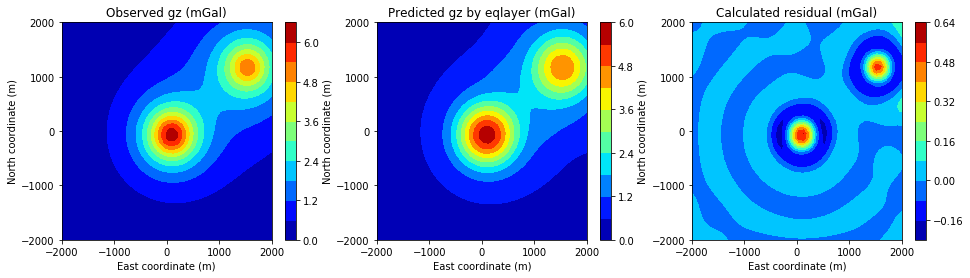

In [80]:
pyplot.figure(figsize=(16, 4))

pyplot.subplot(1, 3, 1)
pyplot.contourf(yo.reshape(ndata,ndata), xo.reshape(ndata,ndata), 
                gz.reshape(ndata,ndata), 10, cmap = pyplot.cm.jet)
pyplot.title('Observed gz (mGal)')
pyplot.xlabel('East coordinate (m)')
pyplot.ylabel('North coordinate (m)')
pyplot.xticks(numpy.linspace(xo.min(), xo.max(), 5))
pyplot.yticks(numpy.linspace(yo.min(), yo.max(), 5))
pyplot.colorbar()

pyplot.subplot(1, 3, 2)
pyplot.contourf(yo.reshape(ndata,ndata), xo.reshape(ndata,ndata), 
                gz_predicted.reshape(ndata,ndata), 10, cmap = pyplot.cm.jet)
pyplot.title('Predicted gz by eqlayer (mGal)')
pyplot.xlabel('East coordinate (m)')
pyplot.ylabel('North coordinate (m)')
pyplot.xticks(numpy.linspace(xo.min(), xo.max(), 5))
pyplot.yticks(numpy.linspace(yo.min(), yo.max(), 5))
pyplot.colorbar()

pyplot.subplot(1, 3, 3)
pyplot.contourf(yo.reshape(ndata,ndata), xo.reshape(ndata,ndata), 
                (gz-gz_predicted).reshape(ndata,ndata), 10, cmap = pyplot.cm.jet)
pyplot.title('Calculated residual (mGal)')
pyplot.xlabel('East coordinate (m)')
pyplot.ylabel('North coordinate (m)')
pyplot.xticks(numpy.linspace(xo.min(), xo.max(), 5))
pyplot.yticks(numpy.linspace(yo.min(), yo.max(), 5))
pyplot.colorbar()

pyplot.show()

In [ ]:
### Test for tensor elements:
# gzx, gzy, gzz